In [132]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [133]:
# Download necessary NLTK data for stopwords and lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Rajesh
[nltk_data]     Pabbati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rajesh
[nltk_data]     Pabbati\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Loading and Preprocessing

In [135]:
# Load the dataset
data = pd.read_csv('Copy of ArticlesMarch2018.csv')

In [136]:
data.head(1)

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,01-03-2018 00:17,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207


In [137]:
# Extract headlines from the dataset
headlines = data['headline'].values

In [138]:
# Function to clean and preprocess text
stop_words = set(stopwords.words('english'))  # Set of English stopwords
lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer

def clean_text(text):
    """
    Clean and preprocess the text by:
    - Converting to lowercase
    - Removing numbers
    - Removing extra spaces
    - Removing punctuations
    - Removing stopwords and lemmatizing words
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

In [139]:
# Apply the cleaning function to all headlines
headlines = [clean_text(headline) for headline in headlines]

In [140]:
# Tokenization: Convert text into sequences of integers
tokenizer = Tokenizer()  # Initialize tokenizer
tokenizer.fit_on_texts(headlines)  # Fit tokenizer on the text data
total_words = len(tokenizer.word_index) + 1  # Total number of unique words (plus one for padding)

In [141]:
# Convert text sequences into numerical sequences
input_sequences = []
for line in headlines:
    token_list = tokenizer.texts_to_sequences([line])[0]  # Convert text to sequence of integers
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]  # Create n-gram sequence
        input_sequences.append(n_gram_sequence)  # Add sequence to list

In [142]:
# Pad sequences to ensure uniform input size
max_sequence_len = max([len(seq) for seq in input_sequences])  # Determine the maximum sequence length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))  # Pad sequences

In [143]:
# Prepare predictors (X) and labels (y)
X, y = input_sequences[:,:-1], input_sequences[:,-1]  # Separate predictors and labels
y = to_categorical(y, num_classes=total_words)  # One-hot encode the labels

In [144]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

# Model Building (Bidirectional LSTM)

In [146]:
# Initialize the sequential model
model = Sequential()
model.add(Embedding(total_words, 100))  # Embedding layer to convert words into dense vectors (100 dimensions)
model.add(Bidirectional(LSTM(150, return_sequences=True)))  # Bidirectional LSTM layer to capture context from both directions
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting (20% dropout rate)
model.add(LSTM(100))  # LSTM layer to learn dependencies from sequences
model.add(Dense(total_words, activation='softmax'))  # Dense output layer for prediction (softmax activation for multi-class classification)

In [147]:
# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adam optimizer with initial learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])  # Compile the model with categorical crossentropy loss

# Model Training with Learning Rate Scheduler

In [149]:
# Callbacks: learning rate scheduler, model checkpoint, and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5, verbose=1)  # Reduce learning rate when validation loss plateaus
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)  # Save the best model based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Stop training if no improvement and restore the best weights

In [150]:
# Train the model
epochs = 20
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler, checkpoint, early_stopping], verbose=1)  # Train with callbacks

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0106 - loss: 8.0018
Epoch 1: val_loss improved from inf to 8.00157, saving model to best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.0107 - loss: 8.0018 - val_accuracy: 0.0206 - val_loss: 8.0016 - learning_rate: 0.0010
Epoch 2/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0119 - loss: 7.6520
Epoch 2: val_loss did not improve from 8.00157
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0119 - loss: 7.6516 - val_accuracy: 0.0206 - val_loss: 8.3134 - learning_rate: 0.0010
Epoch 3/20
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0145 - loss: 7.4046
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 8.00157
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0145 - loss: 7.4046 - val_accuracy: 0.0206 - val_loss: 8.5632 - learning_rate: 0.0010
Epoch 4/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accur

# Text Generation Function

In [152]:
def generate_headline(seed_text, next_words, max_sequence_len):
    """
    Generate text by predicting the next words given a seed text.
    """
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]  # Convert seed text to sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  # Pad sequence
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)  # Predict next word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word  # Find the corresponding word
                break
        seed_text += " " + output_word  # Append the predicted word to the seed text
    return seed_text

In [153]:
# Example usage of the text generation function
seed_text = "breaking news"
generated_headline = generate_headline(seed_text, next_words=5, max_sequence_len=max_sequence_len)
print("Generated Headline:", generated_headline)  # Print the generated headline

Generated Headline: breaking news trump trump trump trump trump


# Plotting the Training and Validation Accuracy

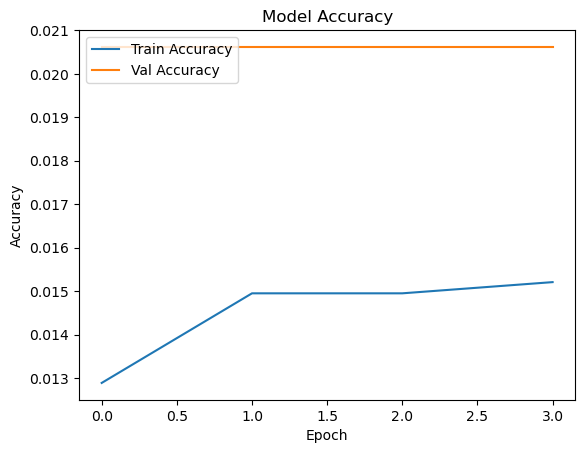

In [155]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Val Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Title of the plot
plt.ylabel('Accuracy')  # Y-axis label
plt.xlabel('Epoch')  # X-axis label
plt.legend(loc='upper left')  # Legend position
plt.show()  # Display the plot